In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate
from transformers import AutoTokenizer
import evaluate
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=d14d33144ea1d851df9b36bd5771e9cb5ef217138cbf19badb967cad1c88b8c6
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0

In [32]:
!pip install nltk
!pip install git+https://github.com/salaniz/pycocoevalcap


  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-4n5a5gtn
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-4n5a5gtn
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=123173b23fb2ec43edbc66f84020757b87cb81fa5d8b319d94f633ed3adf9ef7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_1ixqjg/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [33]:
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [53]:
text_data = pd.read_csv('/content/drive/MyDrive/flickr/captions.txt', sep='|')
text_data

,image_name,caption_number,caption_text
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,0,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,1,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,2,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,3,A rock climber in a red shirt .


In [46]:
text_data = pd.read_csv('/content/drive/MyDrive/flickr/captions.txt', sep='|')
text_data.rename(columns={"caption_number":"image_repeat","caption_text":"caption"},inplace=True)
text_data.drop(text_data[text_data['image_name']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [47]:
# Drop rows with given value of column
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)

# text_data_train = text_data[text_data['image_repeat']==1]
# text_data_train.reset_index(drop=True, inplace=True)
text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)
text_data_train.shape, text_data_val.shape

((32364, 3), (8091, 3))

In [ ]:
batch_size = 32
epochs = 20

In [48]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.10.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.2.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.9.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.2.crossattention.self.key.weight', 'bert.encoder.layer.7.crossattention.self.key.bias', 'bert.encoder.layer.2.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.7.crossattention.self.query.weight', 'bert.encoder.layer.2.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.10.crossattention.self.query.bias', 'bert.encoder.layer.9.crossattention.self.query.weight', 'bert.encoder.layer.5.crossattention.self.value.bias', 'bert.encoder.layer.10.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encode

In [51]:
from torch.utils.data import Dataset
# from datasets import Dataset
image_height = 224
image_width = 224

class ImageCaptionDataset(Dataset):
    def __init__(self, image_path, text_df, tokenizer, image_height,image_width):
        self.image_path = image_path
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width

    def __len__(self):
        return self.text_df.shape[0]

    def __getitem__(self,index):
        path_filename = self.image_path + "/" + text_data_train.iloc[index]['image_name']
        print("Current file path:", path_filename)
        image = np.array(Image.open( path_filename ).resize((self.image_width, self.image_height)), dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0))
        caption_token = self.tokenizer( text_data_train.iloc[index]['caption'], add_special_tokens=True, padding="max_length", max_length=32, truncation = True  ).input_ids
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]
        return {"pixel_values": image.squeeze(), "caption_token": torch.tensor(caption_token)} #"caption":self.captions[index]}


train_dataset = ImageCaptionDataset( image_path="/content/drive/MyDrive/flickr/images/", text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataset = ImageCaptionDataset( image_path="/content/drive/MyDrive/flickr/images/", text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )


In [54]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [55]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print(device)
# Set GPU/CPU
model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [25]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 59s 261ms/step - loss: 2.1934


In [26]:
# save the model
model.save('/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.541638
BLEU-2: 0.310843


In [40]:
eval_bleu, eval_meteor, eval_cider, eval_rouge = [], [], [], []

# Create lists for reference and hypothesis captions
references = {}
hypotheses = {}

for i in tqdm(range(len(test))):
    image_id = test[i]
    reference_captions = mapping.get(image_id, [])
    references[image_id] = reference_captions
    hypotheses[image_id] = [' '.join(predicted[i])]

# BLEU
bleu_scorer = Bleu()
bleu_score, _ = bleu_scorer.compute_score(references, hypotheses)
eval_bleu.append(bleu_score)

# METEOR
meteor_scorer = Meteor()
meteor_score, _ = meteor_scorer.compute_score(references, hypotheses)
eval_meteor.append(meteor_score)

# CIDEr
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(references, hypotheses)
eval_cider.append(cider_score)

# ROUGE (optional)
rouge_scorer = Rouge()
rouge_score, _ = rouge_scorer.compute_score(references, hypotheses)
eval_rouge.append(rouge_score)

# Print the evaluation metrics
print("BLEU: %f" % np.mean(eval_bleu))
print("METEOR: %f" % np.mean(eval_meteor))
print("CIDEr: %f" % np.mean(eval_cider))
print("ROUGE: %f" % np.mean(eval_rouge))



  0%|          | 0/810 [00:00<?, ?it/s]

{'testlen': 8742, 'reflen': 8637, 'guess': [8742, 7932, 7122, 6312], 'correct': [4735, 1415, 525, 161]}
ratio: 1.0121569989578543
BLEU: 0.290246
METEOR: 0.219775
CIDEr: 0.310206
ROUGE: 0.454622


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join( "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq two boys are playing on trampoline endseq
startseq two kids in black trunks bouncing on wet trampoline endseq
startseq two teenage boys in black swim trunks play on trampoline endseq
startseq two wet boys in swim trunks are sitting on trampoline endseq
startseq young laughing boys on wet vinyl mat endseq
--------------------Predicted--------------------
startseq boy in black coat is being pulled into the water endseq


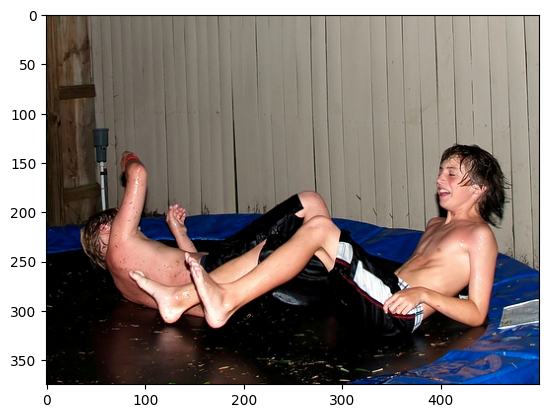

In [42]:
generate_caption("3736786640_70df13be2c.jpg")

---------------------Actual---------------------
startseq man riding bike through the forest endseq
startseq mountain biker rides through shady trail endseq
startseq mountain biker travels along dirt trail inside heavily wooded area endseq
startseq person biking near trees endseq
startseq bicyclist in racing gear rides through forest area endseq
--------------------Predicted--------------------
startseq man on bike is riding through shady trail endseq


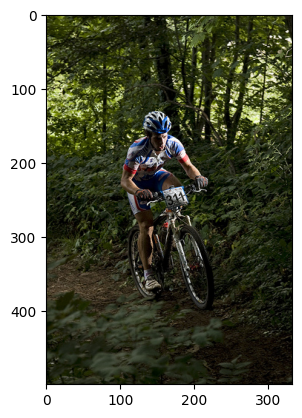

In [43]:
generate_caption("3721082512_8277087f3f.jpg")

---------------------Actual---------------------
startseq man swings golf club while the person to his left waves an arm endseq
startseq man teeing off on golf course with large building in the background endseq
startseq "two men are standing on golf course with large ornate building in the background ." endseq
startseq two people are on golf course playing golf endseq
startseq two people are playing golf on golf course endseq
--------------------Predicted--------------------
startseq two people are playing golf golf endseq


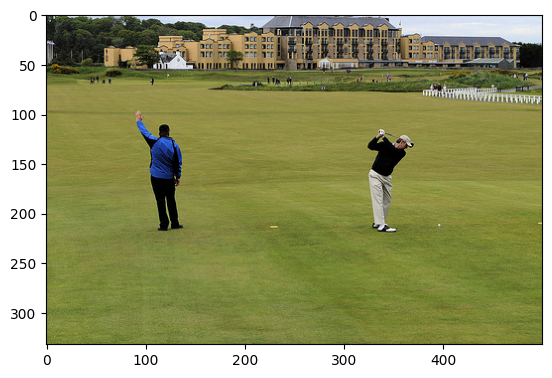

In [44]:
generate_caption("3638783120_f600ceb19d.jpg")